Given a set of trajectories built with different values of $\lambda$ and b, we will analize the general properties of each ensemble and try to derive techniques to characterize them.

Each ensemble (1000 trajectories), have been built by initializing the system at a random initial condition in the unit circle, run with a noise of $\sigma$ = 0.1 for a several number of steps (timestep = 0.01 sec). Then, each trajectory was displaced to match the closest point to (x, y)= (1.0, 0.0) as the initial point, eliminating the previous data.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

import bz2
import pickle
import _pickle as cPickle
import pathlib

from tqdm import tqdm, auto
from tqdm.notebook import tqdm

from functools import reduce

In [3]:
file = pathlib.Path('trajectories_multiple_initial_conditions.pbz2')
if file.exists ():
    print('Trajectories already calculated, loading and decompressing data...')
    trajs_o = bz2.BZ2File(file, 'rb')
    trajs_o = cPickle.load(trajs_o)

Trajectories already calculated, loading and decompressing data...


The simulated $\lambda$ values are:

In [4]:
lambdas = trajs_o.keys()
print(lambdas)

dict_keys([0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0])


Let's see how each ensemble looks...

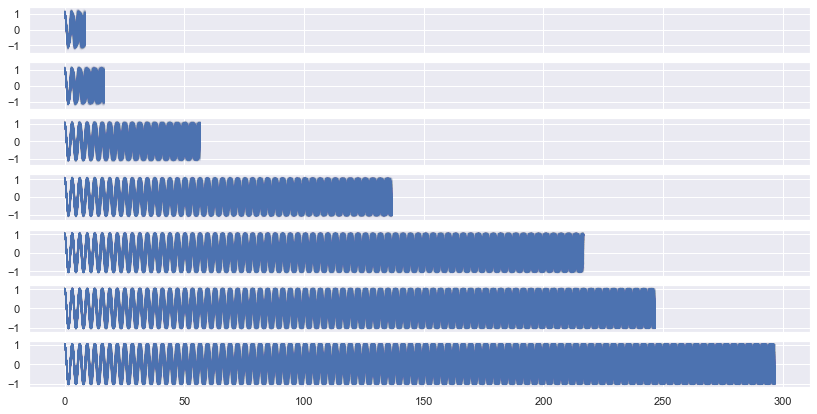

In [5]:
fig, ax = plt.subplots(7, figsize = (14,7), sharex = True)
for i, l in enumerate(lambdas):
    #plot only x(t)
    for t in trajs_o[l]:
        ax[i].plot(np.arange(len(t))*0.01, t[:,0], 'b', alpha = 0.01, label = str(l))

The following function, calculates the mean trajectory of the ensemble:

In [6]:
def mean_traj(rs):
    n_traj = len(rs)
    len_traj = len(rs[0])
    X = np.empty((n_traj, len_traj))
    Y = np.empty((n_traj, len_traj))
    for i in range(n_traj):
        X[i,:] = rs[i][:,0]
        Y[i,:] = rs[i][:,1]
    return np.mean(X, axis = 0)**2 + np.mean(Y, axis = 0)**2

The evolution of the mean $r^2 = x^2 + y^2$ can easily viewed in the following plot

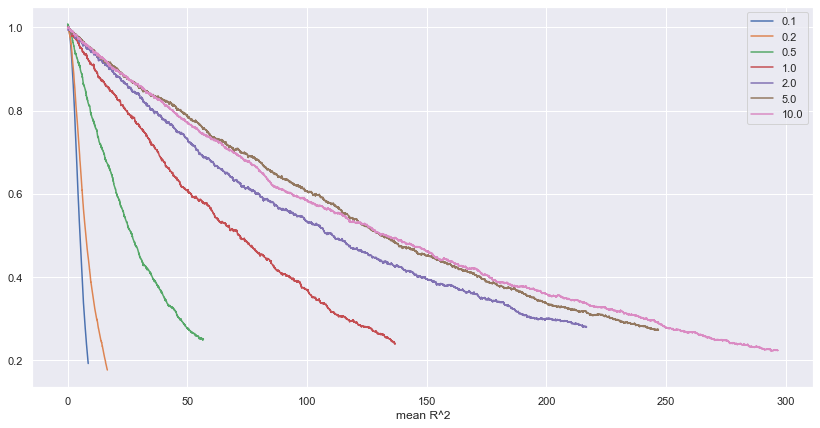

In [7]:
fig, ax = plt.subplots(figsize=(14,7))
for i in lambdas:
    traj = mean_traj(trajs_o[i])
    ts = np.arange(len(traj))*0.01
    plt.plot(ts, traj, label = str(i))
plt.xlabel('Time (sec)')
plt.xlabel('mean R^2')
plt.legend()
plt.show()

Each curve can be approximated to a sigmoid function. In this case, we use the one described in sigmoid3, which has 3 parameters.

In [8]:
from scipy.optimize import fsolve, curve_fit

def sigmoid(x, x0, k):
    """
    Sigmoid function between 0 and 1, variable slope k and x0 midpoint position
    """
    return 1 / (1 + np.exp(-k*(x-x0)))

def sigmoid2(x, x0, k, h):
    """
    Sigmoid function between 0 and h, variable slope k and x0 midpoint position
    """
    return h / (1 + np.exp(-k*(x-x0)))

def sigmoid3(x, x0, k1, k2):
    """
    double sig
    """
    return np.exp(-k1*(x-x0)) / (1 + np.exp(-k2*(x-x0)))


def monoexp(x, x0, k):
    return np.exp(-k*(x-x0))

def biexp(x, A, k1, k2):
    return A*np.exp(-k1*x) + (1.0 - A)*np.exp(-k2*x)

def linear(x, A, B):
    return A*x + B

# Non-linear curve fitting using sigmoid function
def fit_r(func, x_data, y_data):
    
    if func == sigmoid:
        p0 = [np.median(x_data),1] # this is an mandatory initial guess
    elif func == sigmoid2:
        p0 = [np.median(x_data),1, np.max(y_data)] # this is an mandatory initial guess
    elif func == sigmoid3:
        p0 = [np.median(x_data),1e-2, 1e-2] # this is an mandatory initial guess
    elif func == monoexp:
        p0 = [-1, 0] # this is an mandatory initial guess
    elif func == biexp:
        p0 = [0.1, 0.1, 0.1] # this is an mandatory initial guess
    elif func == linear:
        p0 = [1,1]

        
    popt, _ = curve_fit(func, x_data, y_data, p0)
    
    return popt

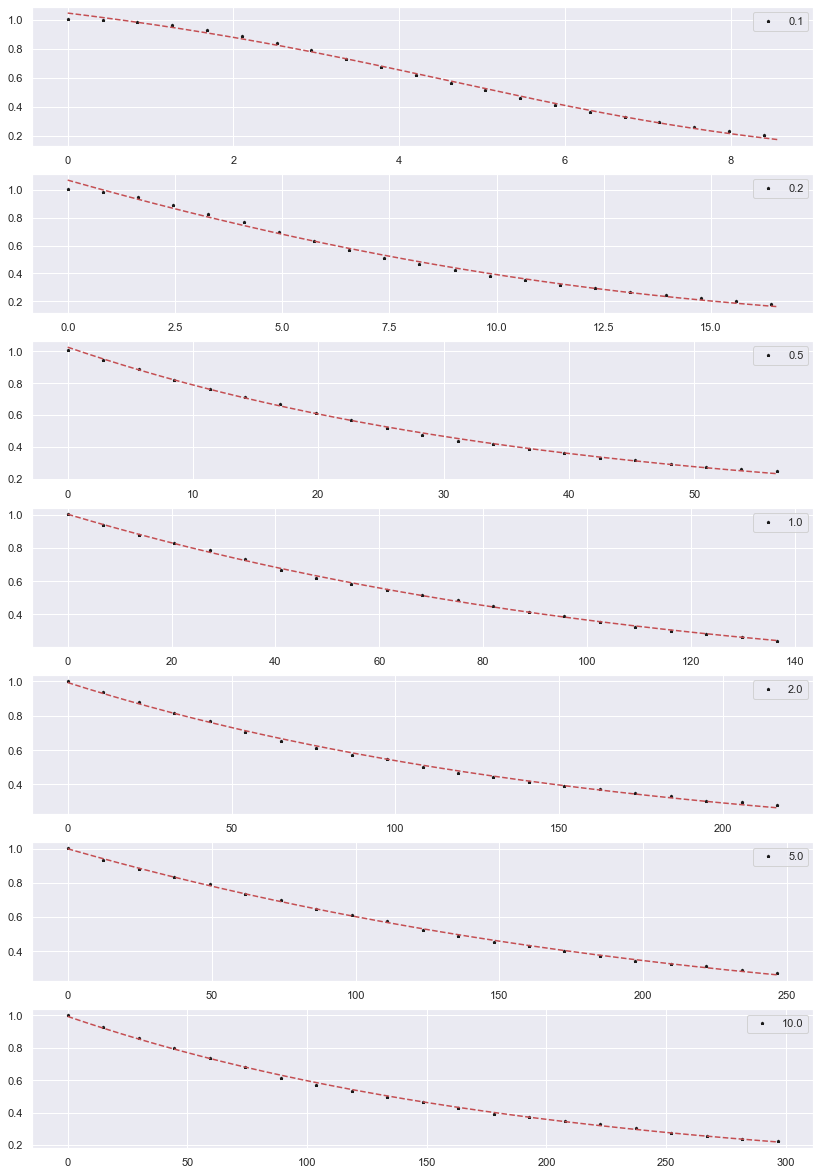

In [9]:
fit_x0 = []
fit_k1 = []
fit_k2 = []
fig, ax = plt.subplots(7, figsize = (14,21))
for i, l in enumerate(lambdas):
    traj = mean_traj(trajs_o[l])
    ts = np.arange(len(traj))*0.01
    
    popt = fit_r(sigmoid3, ts, traj)
    fit_x0.append(popt[0])
    fit_k1.append(popt[1])
    fit_k2.append(popt[2])
    
    ax[i].plot(ts[::int(len(traj)/20)], traj[::int(len(traj)/20)], 'k*', alpha = 1, markersize = 3, label = str(l))
    ax[i].plot(ts, sigmoid3(ts, *popt), 'r', linestyle = '--');
    ax[i].legend()

The fitted parameters have the following dependence with $\lambda$

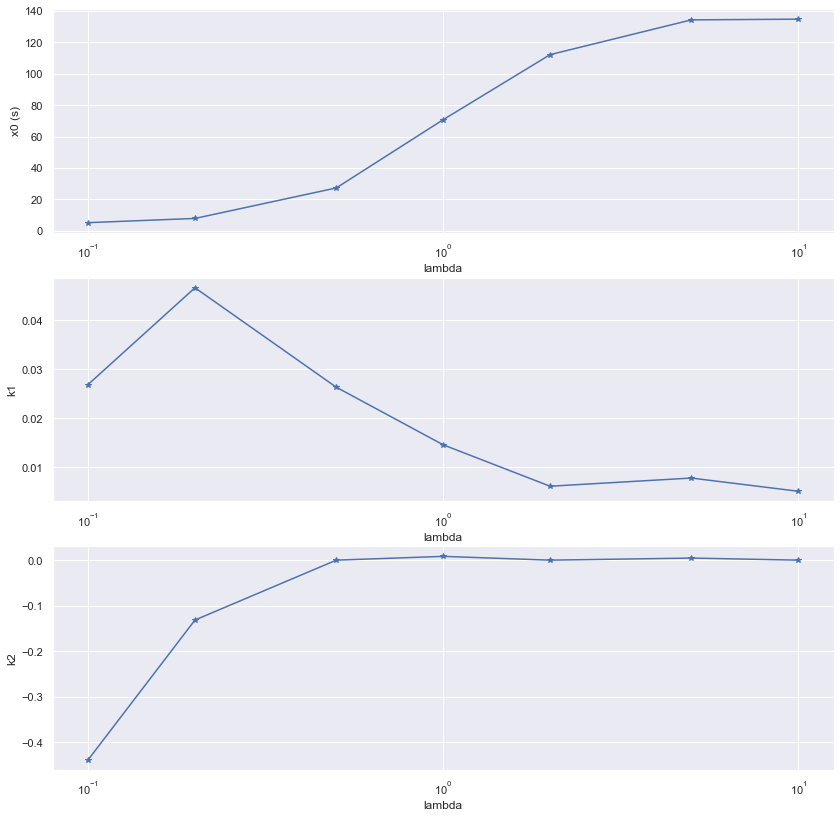

In [10]:
fig, ax = plt.subplots(3, figsize = (14,14))
ax[0].plot(list(lambdas), fit_x0,'*-', label = 'x0')
ax[0].set_xscale('log')
ax[0].set_xlabel('lambda')
ax[0].set_ylabel('x0 (s)')

ax[1].plot(list(lambdas), fit_k1,'*-', label = 'k1')
ax[1].set_xscale('log')
ax[1].set_xlabel('lambda')
ax[1].set_ylabel('k1')

ax[2].plot(list(lambdas), fit_k2,'*-', label = 'k2')
ax[2].set_xscale('log')
ax[2].set_xlabel('lambda')
ax[2].set_ylabel('k2');

Let's try to analyze each trajectory, measuring the error with respect to the limit cycle

In [34]:
def digitize(trajectory, bins):
    x = trajectory[:,0]
    y = trajectory[:,1]
    counts, xedges, yedges = np.histogram2d(x, y, bins = bins)
    return counts/len(x)

def error(target_counts, noise_counts):
    return np.sqrt(sum(sum((target_counts - noise_counts)**2)))

def error_traj(target_digitized, trajectories, npoints):
    error_vals = []
    for t in trajectories:
        tt = np.hstack((t[:npoints,0].reshape(t[:npoints,0].size,1), t[:npoints,1].reshape(t[:npoints,1].size,1)))
        error_vals.append(error(target_digitized, digitize(tt, bins)))
    return np.array(error_vals)

bins = np.linspace(-1.4,1.4,513)

theta = np.linspace(0, 2*np.pi, 5001)
x_target = 1.0*np.cos(theta)
y_target = 1.0*np.sin(theta)
target_trajectory = np.hstack((x_target.reshape(x_target.size,1), y_target.reshape(y_target.size,1)))

target_digitized = digitize(target_trajectory, bins)

In [71]:
error_dict = {}
for l in trajs_o.keys():
    error_dict[l] = error_traj(target_digitized, trajs_o[l], 858)

In [72]:
error_df = pd.DataFrame(error_dict)

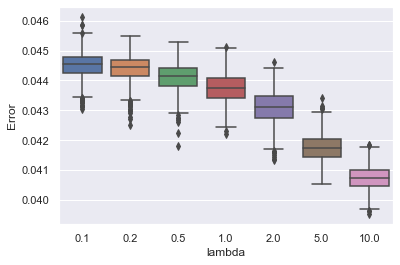

In [73]:
sns.boxplot(data = error_df)
plt.xlabel('lambda')
plt.ylabel('Error');

In [74]:
mean_dict = {}
std_dict = {}
min_dict = {}
max_dict = {}
for l in trajs_o.keys():
    tmp_m = []
    tmp_s = []
    tmp_mi = []
    tmp_ma = []
    for t in trajs_o[l]:
        r = t[:858,0]**2 + t[:858,1]**2
        tmp_m.append(np.mean(r))
        tmp_s.append(np.std(r))
        tmp_mi.append(np.min(r))
        tmp_ma.append(np.max(r))
    mean_dict[l] = tmp_m
    std_dict[l] = tmp_s
    min_dict[l] = tmp_mi
    max_dict[l] = tmp_ma

In [75]:
mean_df = pd.DataFrame(mean_dict)
std_df = pd.DataFrame(std_dict)
min_df = pd.DataFrame(min_dict)
max_df = pd.DataFrame(max_dict)

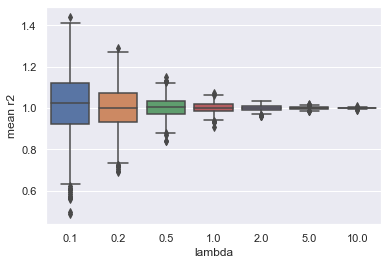

In [76]:
sns.boxplot(data = mean_df)
plt.xlabel('lambda')
plt.ylabel('mean r2');

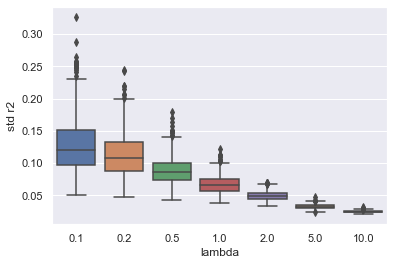

In [77]:
sns.boxplot(data = std_df)
plt.xlabel('lambda')
plt.ylabel('std r2');

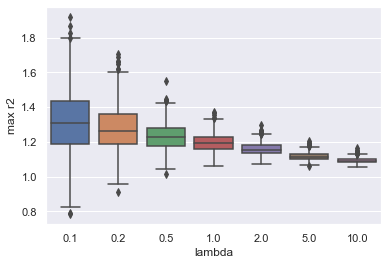

In [78]:
sns.boxplot(data = max_df)
plt.xlabel('lambda')
plt.ylabel('max r2');

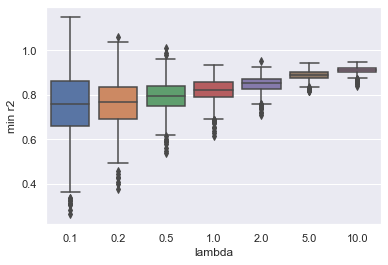

In [79]:
sns.boxplot(data = min_df)
plt.xlabel('lambda')
plt.ylabel('min r2');

Let's build a dataset with the features calculated for each trajectory

In [80]:
error_df_melt = pd.melt(error_df)
error_df_melt.columns = ['lambda', 'error']
mean_df_melt = pd.melt(mean_df)
mean_df_melt.columns = ['lambda', 'mean']
std_df_melt = pd.melt(std_df)
std_df_melt.columns = ['lambda', 'std']
min_df_melt = pd.melt(min_df)
min_df_melt.columns = ['lambda', 'min']
max_df_melt = pd.melt(max_df)
max_df_melt.columns = ['lambda', 'max']

In [81]:
data_frames = [error_df_melt, mean_df_melt, std_df_melt, min_df_melt, max_df_melt]
df_merged = reduce(lambda  left, right: pd.merge(left, right, left_index = True, right_index = True), data_frames)
df_merged.columns = ['lambda', 'error', 'x1', 'mean', 'x2', 'std', 'x3','min', 'x4', 'max']
df_merged = df_merged.drop(['x1','x2','x3', 'x4'], axis = 1)

In [82]:
df_merged

,lambda,error,mean,std,min,max
0,0.1,0.044556,1.111544,0.125462,0.855381,1.436975
1,0.1,0.044501,1.105068,0.187132,0.757385,1.455295
2,0.1,0.044056,1.046772,0.120303,0.852449,1.317812
3,0.1,0.044135,0.962220,0.080348,0.805271,1.234457
4,0.1,0.044338,0.909320,0.139993,0.699554,1.224657
...,...,...,...,...,...,...
6995,10.0,0.040973,0.999374,0.023489,0.918764,1.087338
6996,10.0,0.040820,0.997698,0.024747,0.913330,1.103592
6997,10.0,0.040671,0.994559,0.025866,0.894515,1.069040
6998,10.0,0.040497,1.000633,0.023679,0.908530,1.087639


In [83]:
df_merged.corr()

,lambda,error,mean,std,min,max
lambda,1.000000,-0.918014,-0.034387,-0.685735,0.510981,-0.528742
error,-0.918014,1.000000,0.014111,0.756580,-0.557900,0.553221
mean,-0.034387,0.014111,1.000000,0.085497,0.646296,0.673430
std,-0.685735,0.756580,0.085497,1.000000,-0.625132,0.725301
min,0.510981,-0.557900,0.646296,-0.625132,1.000000,0.003159
max,-0.528742,0.553221,0.673430,0.725301,0.003159,1.000000


Let's try to fit a classifier. Out-of-box RandomForest!

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

Solo clasifico con error

In [85]:
y = df_merged['lambda'].values
X = df_merged.drop(['lambda'], axis = 1)

In [86]:
ymapped = [0]*1000 + [1]*1000 + [2]*1000+[3]*1000+[4]*1000+[5]*1000+[6]*1000 

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, ymapped, test_size=0.33, random_state=42)

In [88]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

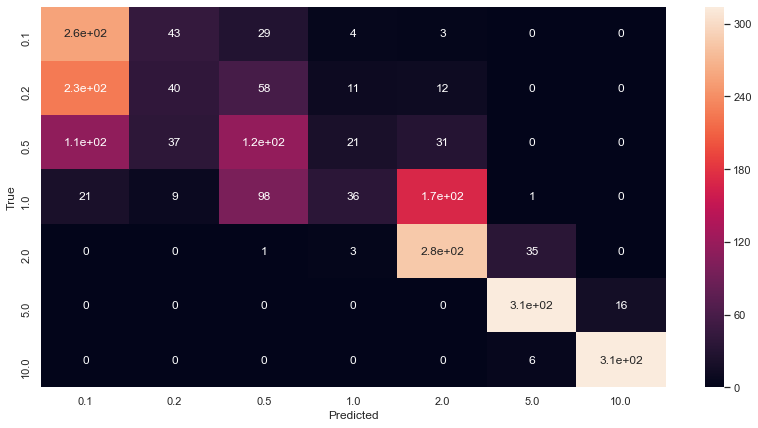

In [89]:
CM = confusion_matrix(y_test, clf.predict(X_test))
plt.figure(figsize=(14,7))
sns.heatmap(CM, annot=True, xticklabels= lambdas, yticklabels=lambdas)
plt.xlabel('Predicted')
plt.ylabel('True');

In [59]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.41      0.76      0.54       335
           1       0.31      0.12      0.17       347
           2       0.38      0.36      0.37       319
           3       0.48      0.11      0.18       335
           4       0.57      0.88      0.69       324
           5       0.88      0.95      0.92       330
           6       0.95      0.98      0.97       320

    accuracy                           0.59      2310
   macro avg       0.57      0.59      0.55      2310
weighted avg       0.57      0.59      0.54      2310



858